# **<h1 align="center">Data Mining 2024-25</h3>**
## **<h3 align="center">Customer Segmentation - ABCDEats Inc.</h3>**
### **<h3 align="center">Clustering on Purchasing Habits Perspective</h3>**


**Group 10 members:**<br>Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Marco Galão  - r20201545@novaims.unl.pt - r20201545<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub  - 20240505@novaims.unl.pt - 20240505<br>

<a id = "toc"></a>

# Table of Contents

* [1. Import the Libraries](#import_libraries)
* [2. Import the Dataset](#import_dataset)
* [3. Normalization](#normalization)
* [4. Clustering](#clustering)
    * [4.1. K-Means](#k_means)
    * [4.2. K-Medoids](#k_medoids)
    * [4.3. SOM](#som)
    * [4.4. Mean Shift](#mean_shift)
    * [4.5. Hierarchical Clustering](#hierarchical_clustering)
    * [4.6. DBSCAN](#dbscan)
    * [4.7. GMM (Gaussian Mixture Model)](#gmm)
* [5. Hybrid Clustering](#hybrid_clustering)
    * [5.1 K-Means and HC Dendogram](#kmeans_hc)
    * [5.2 HC Dendogram and K-Means](#hc_kmeans)
* [6. Loading Results](#loading_results)




#NOTE: I DON'T REMEMBER EXACTLY THE HYBRID APPROACHES TO DONT FOLLOW BY THE NAME, IF ITS WRONG JUST CORRECT:)





---
In this notebook, we will focus on clustering algorithms for purchasing habits features, which represent one of the segmentation purposes. These features are related with orders. <BR>

We will apply multiple clustering algorithms, such as Self-Organizing Maps (SOM), hierarchical clustering, and k-means, as well as hybrid approaches. The goal is to determine which algorithm provides the most effective clusters by evaluating metrics like R-squared and using visualizations such as t-SNE and UMAP. Once the best clustering algorithm is identified, the resulting dataset with the optimal labels will be stored. <BR>

In Notebook 4, we will merge these clusters with those based on taste to create a more comprehensive customer segmentation.

---

# 1. Import the Libraries <a class="anchor" id="import_libraries"></a>
[Back to ToC](#toc)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from matplotlib.patches import RegularPolygon, Ellipse
import json

#To perform Clustering Algorithms
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.cluster.hierarchy import dendrogram, linkage
from minisom import MiniSom


import warnings
warnings.filterwarnings("ignore")

#Importing the functions created in main.py
from main import *
import importlib
imported_module = importlib.import_module("main")
importlib.reload(imported_module)

#Visualizing the data
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA

In [2]:
## Import Matplotlib functions to create MiniSOM visualizations

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

# 2. Import the Dataset <a class="anchor" id="import_dataset"></a>
[Back to ToC](#toc)<br>

In this section, we import the preprocessed dataset and set the customer_id as the index column. Also, check the first and last 5 rows of the dataset.

In [19]:
# df_clustering = pd.read_csv("../Data/Preprocessed_Data.csv", index_col="customer_id")
df_clustering = pd.read_csv("../Data/df_outliers_labels.csv", index_col="customer_id")
df_clustering.head().T

customer_id,1b8f824d5e,f6d1b2ba63,180c632ed8,4eb37a6705,6aef2b6726
customer_region,2360,4660,4660,4660,8670
customer_age,18,38,26,20,40
vendor_count,2,1,2,2,2
product_count,5,2,3,5,2
chain_orders,1,2,1,0,0
...,...,...,...,...,...
prop_cui_other,0.0,0.0,0.0,0.0,0.0
prop_cui_street food / snacks,0.0,0.0,0.0,0.0,0.0
prop_cui_thai,0.0,0.0,0.0,0.0,0.0
weekend_to_weekday_ratio,2.0,2.0,1.0,1.0,1.0


# 3. Normalization <a class="anchor" id="normalization"></a>
[Back to ToC](#toc)<br>

Let's open the json file witth the categories.

In [4]:
# Load the categories dictionary from the JSON file
with open("categories.json", "r") as file:
    loaded_categories = json.load(file)

print("Categories dictionary has been successfully loaded!")
print(loaded_categories)

Categories dictionary has been successfully loaded!
{'demographics': ['customer_region', 'customer_age', 'city', 'generation_encoded'], 'economic_values': ['avg_order_value', 'customer_age'], 'purchasing_habits': ['first_order', 'chain_orders_prop', 'orders_dawn', 'orders_morning', 'orders_afternoon', 'orders_evening', 'order_recency', 'weekend_to_weekday_ratio'], 'taste': ['prop_cui_cafe', 'prop_cui_chicken dishes', 'prop_cui_chinese', 'prop_cui_indian', 'prop_cui_japanese', 'prop_cui_noodle dishes', 'prop_cui_other', 'prop_cui_street food / snacks', 'prop_cui_thai', 'health_index', 'cui_asian_spending', 'cui_western_spending'], 'categorical': ['last_promo', 'payment_method', 'promo_used', 'city']}


In this notebook, we will focus on clustering from the taste perspective. First, we will select the relevant features and then apply normalization using the `scaled_dataframe` function from `main.py`.

In [5]:
df_scaled= scaled_dataframe(loaded_categories['purchasing_habits'], df_clustering)

After applying the normalization function to the taste features, we will update the list of taste features by appending "_normalized" to the end of each feature name.

In [6]:
purchasing_habits_features_normalized = [feature + '_normalized' for feature in loaded_categories['purchasing_habits']]
purchasing_habits_features_normalized

['first_order_normalized',
 'chain_orders_prop_normalized',
 'orders_dawn_normalized',
 'orders_morning_normalized',
 'orders_afternoon_normalized',
 'orders_evening_normalized',
 'order_recency_normalized',
 'weekend_to_weekday_ratio_normalized']

# 4. Clustering <a class="anchor" id="clustering"></a>
[Back to ToC](#toc)<br>

## 4.1. K-Means <a class="anchor" id="k_means"></a>
[Back to 4. Clustering](#clustering)<br>

## 4.2. K-Medoids <a class="anchor" id="k_medoids"></a>
[Back to 4. Clustering](#clustering)<br>

## 4.3. SOM <a class="anchor" id="som"></a>
[Back to 4. Clustering](#clustering)<br>

In [10]:
from minisom import MiniSom
import numpy as np

def train_som(data, features, M=10, N=10, neighborhood_function='gaussian', 
              topology='hexagonal', learning_rate=0.5, iterations=20000, random_seed=42):
    """
    Trains a Self-Organizing Map (SOM) on the given dataset.
    
    Parameters:
        data (pd.DataFrame): The dataset containing the features for SOM training.
        metric_features (list): List of metric feature column names to be used for training.
        M (int): Number of rows in the SOM grid. Default is 10.
        N (int): Number of columns in the SOM grid. Default is 10.
        neighborhood_function (str): The neighborhood function to use (e.g., 'gaussian', 'bubble').
        topology (str): The topology of the SOM grid ('rectangular' or 'hexagonal').
        learning_rate (float): Initial learning rate. Default is 0.5.
        iterations (int): Number of training iterations. Default is 20000.
        random_seed (int): Random seed for reproducibility. Default is 42.
    
    Returns:
        MiniSom: Trained MiniSom instance.
    """
    n_feats = len(taste_features_normalized)
    som_data = data[taste_features_normalized].values

    # Initialize the SOM
    sm = MiniSom(M, N, n_feats, learning_rate=learning_rate, 
                 topology=topology, neighborhood_function=neighborhood_function, 
                 activation_distance='euclidean', random_seed=random_seed)
    
    # Initialize weights
    sm.random_weights_init(som_data)
    
    # Quantization and topographic errors before training
    print("Before training:")
    print("QE:", np.round(sm.quantization_error(som_data), 4))
    print("TE:", np.round(sm.topographic_error(som_data), 4))
    
    # Train the SOM
    sm.train_batch(som_data, iterations)
    
    # Quantization and topographic errors after training
    print("After training:")
    print("QE:", np.round(sm.quantization_error(som_data), 4))
    print("TE:", np.round(sm.topographic_error(som_data), 4))
    
    return sm


In [ ]:
# # define the metric features to be used in SOM --- > this is a placeholder for now 
# metric_features = ['prop_cui_asian',
#        'prop_cui_beverages', 'prop_cui_cafe', 'prop_cui_chicken dishes',
#        'prop_cui_chinese', 'prop_cui_desserts', 'prop_cui_healthy',
#        'prop_cui_indian', 'prop_cui_italian', 'prop_cui_japanese',
#        'prop_cui_noodle dishes', 'prop_cui_other',
#        'prop_cui_street food / snacks', 'prop_cui_thai']

In [13]:
sm = train_som(df_scaled, purchasing_habits_features_normalized, M=10, N=10, neighborhood_function='gaussian')

Before training:
QE: 0.1921
TE: 0.8522
After training:
QE: 0.1297
TE: 0.2943


In [ ]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)




    return sf 

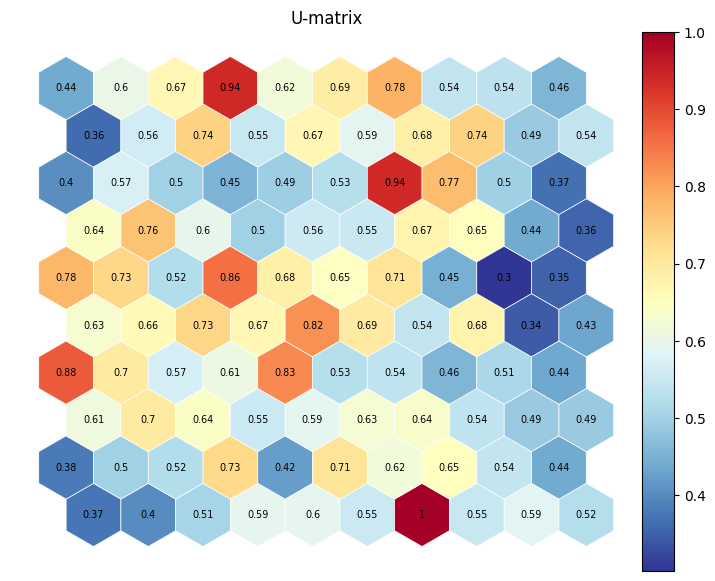

In [15]:
figsize=(10,7)

umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    annot=True
                    )

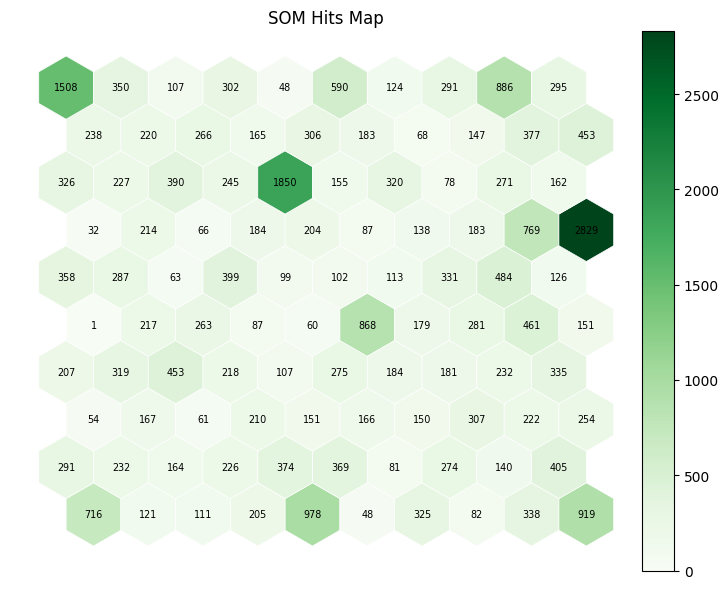

In [ ]:
hitsmatrix = sm.activation_response(df_scaled[purchasing_habits_features_normalized].values)

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    annot=True
                    )

In [17]:
# What are these weights?
weights = sm.get_weights()
weights.shape

(10, 10, 14)

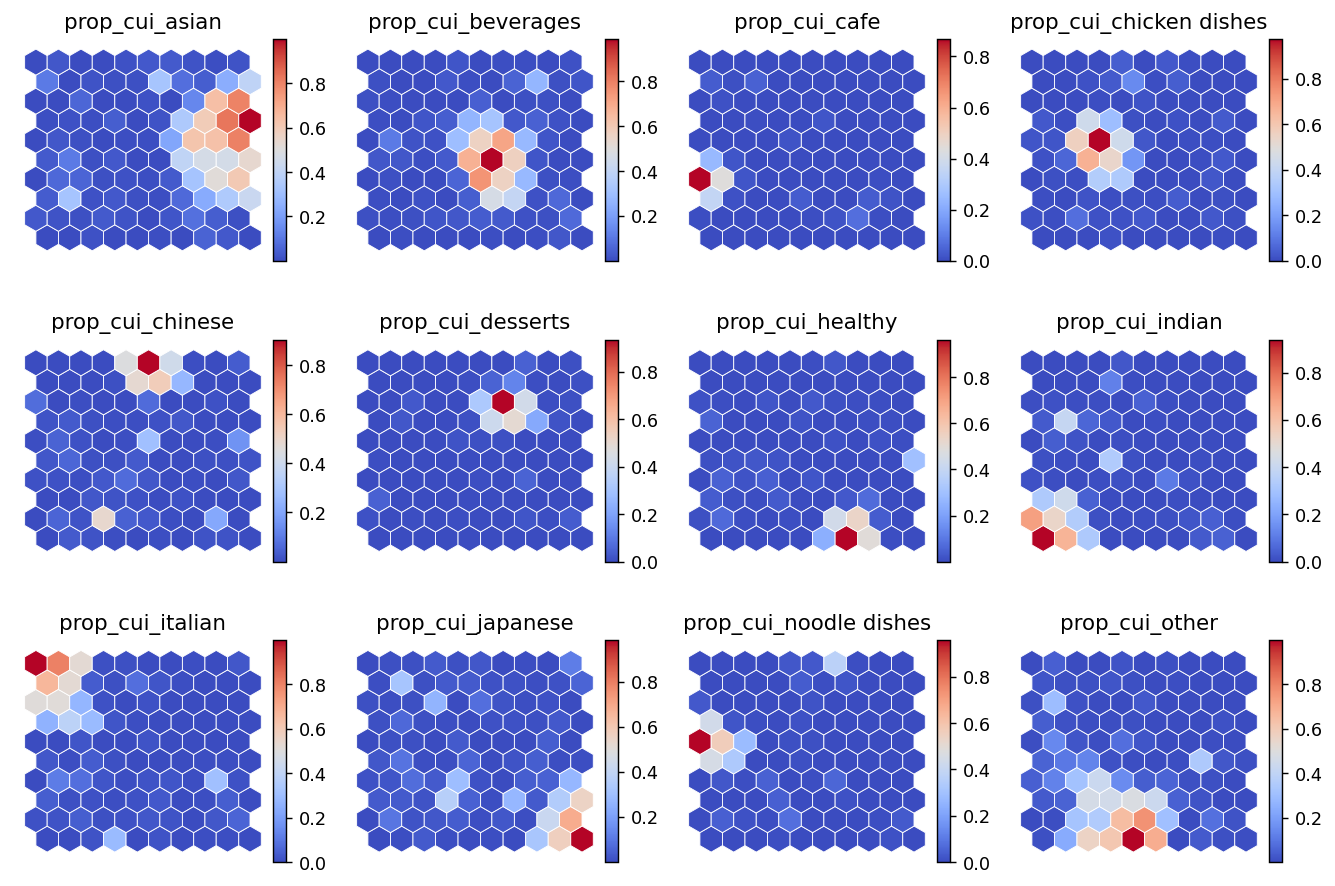

In [19]:
##############################
# Plot Component Planes
##############################

figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(3,4,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(purchasing_habits_features_normalized)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=purchasing_habits_features_normalized[cpi],
                    cmap=cm.coolwarm,
                    )

## 4.4. Mean Shift <a class="anchor" id="mean_shift"></a>
[Back to 4. Clustering](#clustering)<br>

Mean Shift is one of the density based algorithms available to perform clustering. To identify the optimal bandwidth more effectively, let's explore a loop where we select a range of quantiles, printing both the bandwidth and the corresponding number of clusters for each.

In [9]:
# Initialize quantiles and results list
quantiles = [0.04, 0.05, 0.06, 0.08, 0.1, 0.15, 0.2]
results = []

# Loop through different quantiles
for quantile in quantiles:
    # Estimate bandwidth using the given quantile
    bandwidth = estimate_bandwidth(df_scaled[purchasing_habits_features_normalized], quantile=quantile, random_state=1, n_jobs=-1)
    
    # Perform mean-shift clustering with the estimated bandwidth
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
    ms_labels = ms.fit_predict(df_scaled[purchasing_habits_features_normalized])
    
    # Add the labels to a DataFrame for R^2 calculation
    df_with_labels = pd.DataFrame(df_scaled, columns=purchasing_habits_features_normalized)
    df_with_labels['ms_labels'] = ms_labels  # Add labels as a column
    
    # Calculate the number of clusters
    ms_n_clusters = len(np.unique(ms_labels))
    
    # Compute R^2 using the main function
    r2 = get_rsq(df=df_with_labels, feats=purchasing_habits_features_normalized, label_col='ms_labels')
    
    # Append results
    results.append([quantile, bandwidth, ms_n_clusters, r2])

# Create a DataFrame with the results
results_df = pd.DataFrame(results, columns=['Quantile', 'Bandwidth', 'Number of Clusters', 'R^2'])
results_df

,Quantile,Bandwidth,Number of Clusters,R^2
0,0.04,1.969824,19,0.202688
1,0.05,2.076590,13,0.185613
2,0.06,2.167877,6,0.137407
3,0.08,2.322606,3,0.046768
4,0.10,2.451677,3,0.070249
5,0.15,2.706535,2,0.035719
6,0.20,2.903695,1,0.000000


 To aid in our decision-making, we'll plot the $ R^2 $  values for different quantiles and use the elbow method to determine the best quantile for optimal clustering performance.

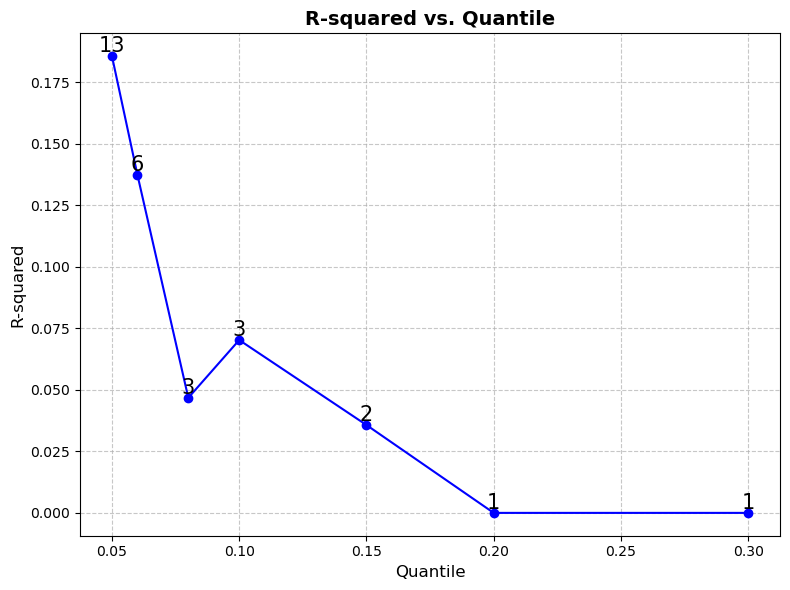

In [8]:
# Create an elbow plot for R-squared vs. Quantile
plt.figure(figsize=(8, 6))
# Plot R-squared vs Quantile (x-axis as Quantile)
plt.plot(results_df['Quantile'], results_df['R^2'], marker='o', linestyle='-', color='b')

# Add labels and title
plt.title('R-squared vs. Quantile', fontsize=14, weight='bold')
plt.xlabel('Quantile', fontsize=12)
plt.ylabel('R-squared', fontsize=12)

# Display the grid
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate the number of clusters above each point
for i in range(len(results_df)):
    plt.text(results_df['Quantile'][i], results_df['R^2'][i], str(results_df['Number of Clusters'][i]),
             ha='center', va='bottom', fontsize=15, color='black')

# Show the plot
plt.tight_layout()
plt.show()

change this

In [14]:
bandwidth = estimate_bandwidth(df_scaled[purchasing_habits_features_normalized], quantile=0.10, random_state=1, n_jobs=-1)

# Perform mean-shift clustering with bandwidth set using estimate_bandwidth
ms = MeanShift(bandwidth= bandwidth, bin_seeding=True, n_jobs=-1)
ms_labels = ms.fit_predict(df_scaled[purchasing_habits_features_normalized])

In [15]:
ms_n_clusters = len(np.unique(ms_labels))
print("Number of estimated clusters : %d" % ms_n_clusters)

Number of estimated clusters : 3


In [16]:
# Concatenating the labels to df
df_concat = pd.concat([df_scaled[purchasing_habits_features_normalized], pd.Series(ms_labels, index=df_scaled[purchasing_habits_features_normalized].index, name="ms_labels")], axis=1)
df_concat.head()

,first_order_normalized,chain_orders_prop_normalized,orders_dawn_normalized,orders_morning_normalized,orders_afternoon_normalized,orders_evening_normalized,order_recency_normalized,weekend_to_weekday_ratio_normalized,ms_labels
customer_id,,,,,,,,,
1b8f824d5e,-1.186149,-0.329769,-0.383628,-0.653882,-0.787886,0.982023,-2.698229,2.140721,0
f6d1b2ba63,-1.186149,0.959949,-0.383628,0.520029,-0.787886,-0.598069,-2.698229,2.140721,0
180c632ed8,-1.186149,-0.329769,-0.383628,-0.066927,-0.311958,-0.598069,-2.655076,0.686206,0
4eb37a6705,-1.186149,-1.619487,-0.383628,0.520029,-0.787886,-0.598069,-2.655076,0.686206,0
6aef2b6726,-1.186149,-1.619487,1.553378,-0.653882,-0.787886,-0.598069,-2.655076,0.686206,0


In [17]:
df_concat["ms_labels"].value_counts()

ms_labels
0    30157
2      691
1       58
Name: count, dtype: int64

Let's use t-SNE to visualize how well the clusters formed by Mean Shift are separated and to gain a deeper understanding of the clustering results. While t-SNE is effective for visualizing high-dimensional data in two dimensions, UMAP is often faster and more efficient, particularly with large datasets. Both methods offer valuable insights, and we can also visualize the clustering results using PCA for a comparative view.

<Figure size 1500x1000 with 0 Axes>

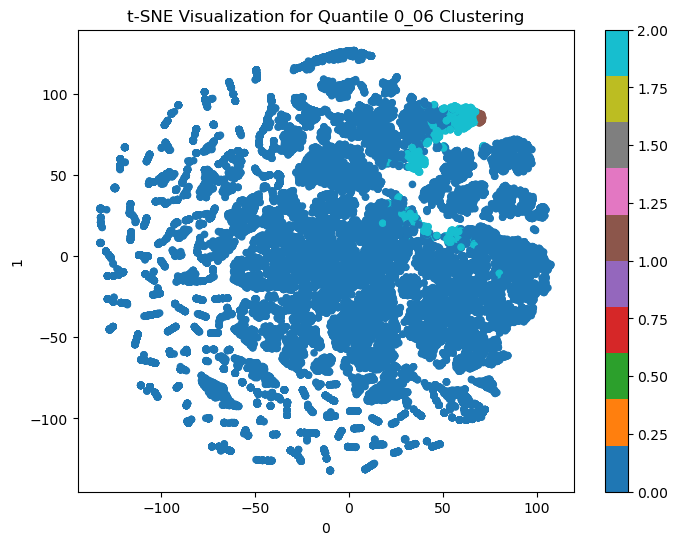

<Figure size 1500x1000 with 0 Axes>

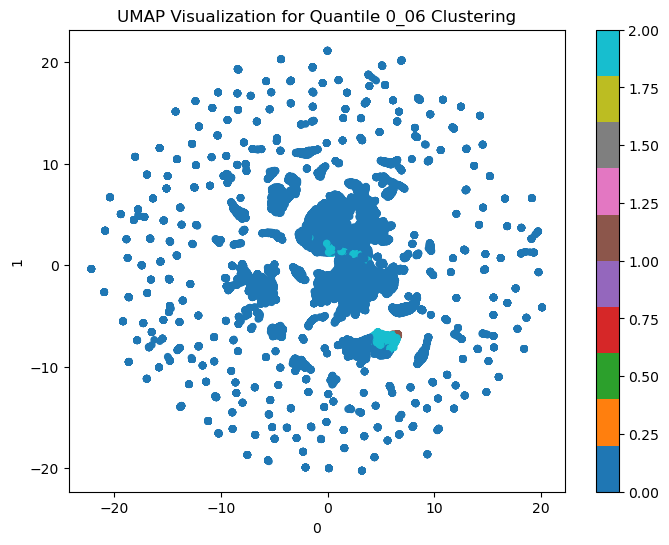

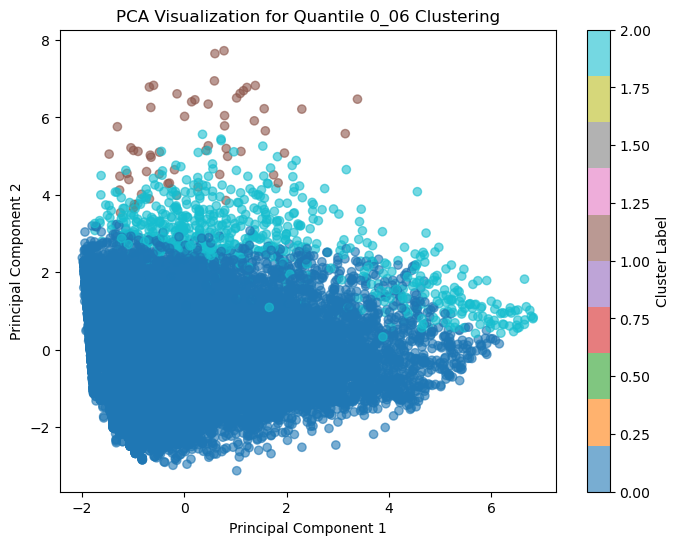

In [ ]:
# Function to plot t-SNE, UMAP, and PCA visualizations
def plot_dimensionality_reduction(df_concat, quantile_label):
    # Perform t-SNE for dimensionality reduction
    two_dim = TSNE(random_state=42).fit_transform(df_concat.drop(columns=[f'ms_labels']))
    
    # Plot t-SNE visualization
    plt.figure(figsize=(15, 10))
    pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_concat[f'ms_labels'], colormap='tab10', figsize=(8,6))
    plt.title(f't-SNE Visualization for Quantile {quantile_label} Clustering')
    plt.show()

    # Perform UMAP for dimensionality reduction
    umap_result = umap.UMAP(random_
                            state=42).fit_transform(df_concat.drop(columns=[f'ms_labels']))
    
    # Plot UMAP visualization
    plt.figure(figsize=(15, 10))
    pd.DataFrame(umap_result).plot.scatter(x=0, y=1, c=df_concat[f'ms_labels'], colormap='tab10', figsize=(8,6))
    plt.title(f'UMAP Visualization for Quantile {quantile_label} Clustering')
    plt.show()

    # Perform PCA for dimensionality reduction (e.g., reducing to 2 components)
    pca_result = PCA(n_components=2, random_state=42).fit_transform(df_concat.drop(columns=[f'ms_labels']))
    
    # Plot PCA visualization
    plt.figure(figsize=(8,6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df_concat[f'ms_labels'], cmap='tab10', alpha=0.6)
    plt.title(f'PCA Visualization for Quantile {quantile_label} Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster Label')
    plt.show()

# Apply the function to both quantiles
plot_dimensionality_reduction(df_concat, '0_06')

## 4.5. Hierarchical Clustering <a class="anchor" id="hierarchical_clustering"></a>
[Back to 4. Clustering](#clustering)<br>

In [ ]:
df_hierarchicalClustering = df_scaled.copy()

Find best linkage method

In [ ]:
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

r2_hc = np.vstack([ get_r2_hc(df_hierarchicalClustering[taste_features_normalized], 
                              link, 
                              max_nclus=max_nclus, 
                              min_nclus=1, 
                              dist="euclidean") 
                              for link in hc_methods])

Define number of clusters based on dendogram

In [ ]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'


hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_hierarchicalClustering[taste_features_normalized])

In [ ]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)



In [ ]:
# Plot the corresponding dendrogram
sns.set_theme()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [ ]:
##########################################
# Visualize the Dendrogram with y_threshold = 75
##########################################

# Plot the corresponding dendrogram
sns.set_theme()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 75
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

Test cluster solution for different amount of clusters

In [ ]:
linkage = 'ward'
distance = 'euclidean'

In [ ]:
# 4 cluster solution
n_clusters = 4

hc4_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc4_labels = hc4_clust.fit_predict(df_hierarchicalClustering[taste_features_normalized])

In [ ]:
# Characterizing the 4 clusters
df_hierarchicalClustering_concat = pd.concat([df_hierarchicalClustering[taste_features_normalized], 
                       pd.Series(hc4_labels, 
                                 name='labels', 
                                 index=df_hierarchicalClustering.index)], 
                    axis=1)

df_hierarchicalClustering_concat.groupby('labels').mean()

In [ ]:
# 5 cluster solution
n_clusters=5

hc5_clust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)
hc5_labels = hc5_clust.fit_predict(df_hierarchicalClustering[taste_features_normalized])

In [ ]:
# Characterizing the 5 clusters
df_hierarchicalClustering_concat = pd.concat([df_hierarchicalClustering[taste_features_normalized], 
                       pd.Series(hc5_labels, 
                                 name='labels', 
                                 index=df_hierarchicalClustering.index)], 
                    axis=1)

df_hierarchicalClustering_concat.groupby('labels').mean()

In [ ]:
pd.crosstab(
    pd.Series(hc5_labels, name='hc5_labels', index=df_hierarchicalClustering.index),
    pd.Series(hc4_labels, name='hc4_labels', index=df_hierarchicalClustering.index),
    )

Final Hierarchical clustering solution

In [ ]:
# final cluster solution
linkage = "ward"
distance = "euclidean"
n_clusters = 4

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels = hclust.fit_predict(df_hierarchicalClustering[taste_features_normalized])

In [ ]:
# Characterizing the final clusters

df_hierarchicalClustering_concat = pd.concat([
    df_hierarchicalClustering[taste_features_normalized], 
    pd.Series(hc_labels, name='labels', index=df_hierarchicalClustering.index)
    ], 
    axis=1)
df_hierarchicalClustering_concat.groupby('labels').mean()

## 4.6. DBSCAN <a class="anchor" id="dbscan"></a>
[Back to 4. Clustering](#clustering)<br>

## 4.7. GMM (Gaussian Mixture Model) <a class="anchor" id="GMM"></a>
[Back to 4. Clustering](#clustering)<br>

The Gaussian Mixture Model (GMM) assumes that the features follow a normal distribution. To assess whether this assumption holds for our data, we'll first plot histograms and boxplots.


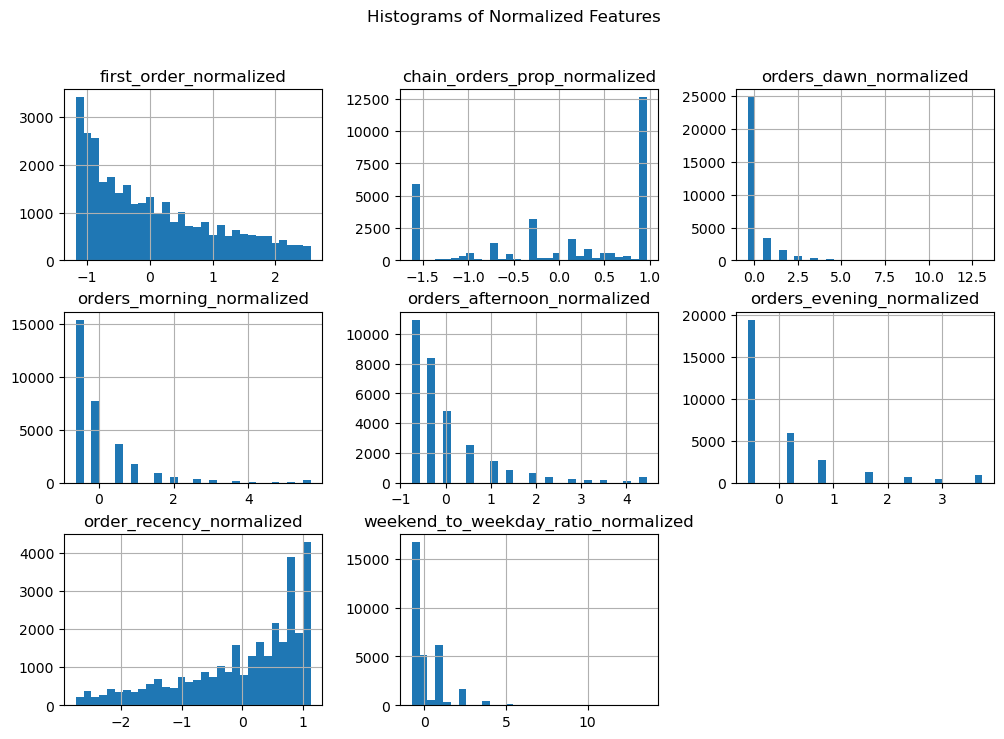

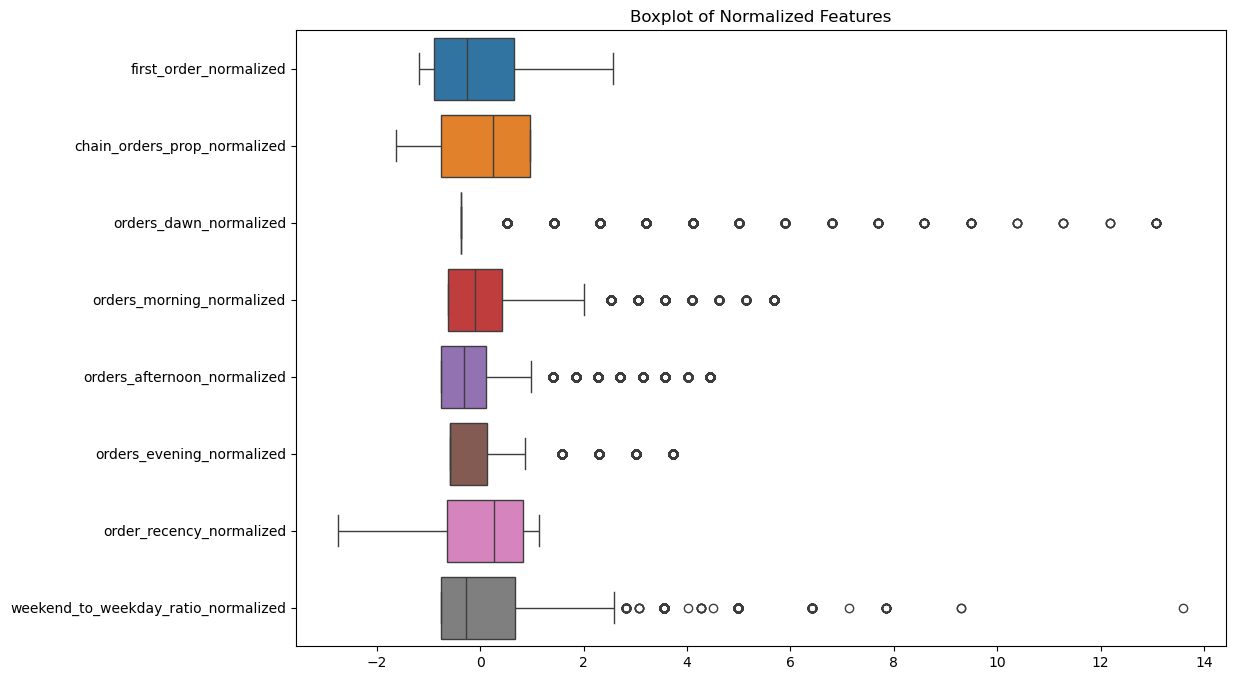

In [20]:
# Histogram for each feature
df_scaled[purchasing_habits_features_normalized].hist(bins=30, figsize=(12, 8))
plt.suptitle('Histograms of Normalized Features')
plt.show()

# Boxplot for each feature
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_scaled[purchasing_habits_features_normalized], orient="h")
plt.title('Boxplot of Normalized Features')
plt.show()


Upon examining the plots, we observe that some features, such as 'First Order' and 'Orders Dawn,' exhibit left skewness, while others, like 'Order Recency,' show right skewness. This mixed distribution suggests that Gaussian Mixture Model (GMM) may not be the most suitable choice for clustering in this case.



# 5. Hybrid Clustering <a class="anchor" id="hybrid_clustering"></a>
[Back to ToC](#toc)<br>

## 5.1. K-Means and HC Dendogram <a class="anchor" id="kmeans_hc"></a>
[Back to 5. Hybrid Clustering](#hybrid_clustering)<br>

## 5.2. HC Dendogram and K-Means <a class="anchor" id="hc_kmeans"></a>
[Back to 5. Hybrid Clustering](#hybrid_clustering)<br>

# 6. Loading Results <a class="anchor" id="loading_results"></a>
[Back to ToC](#toc)<br>

<code style="background:yellow;color:black">For now, I’ve temporarily assigned this task under the mean-shift subtopic. However, once we finalize the clustering algorithm, we’ll likely compare all methods to determine the best cluster labels. At that point, we’ll update the original dataset (`df_clustering`) with an additional column, potentially named `purchasing_habits_labels`, to store the chosen cluster labels. </code>

In [20]:
# Ensure the indices of both dataframes align
if not df_clustering.index.equals(df_concat.index):
    raise ValueError("Indices of df_clustering and df_concat do not align.")

# Add ms_labels as purchasing_habits_labels in df_clustering
df_clustering['purchasing_habits_labels'] = df_concat['ms_labels']

# Verify the addition
df_clustering.head()

,customer_region,customer_age,vendor_count,product_count,chain_orders,first_order,last_order,last_promo,payment_method,CUI_American,...,prop_cui_indian,prop_cui_italian,prop_cui_japanese,prop_cui_noodle dishes,prop_cui_other,prop_cui_street food / snacks,prop_cui_thai,weekend_to_weekday_ratio,taste_labels,purchasing_habits_labels
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,18,2,5,1,0,1,DELIVERY,DIGI,0.00,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2,0
f6d1b2ba63,4660,38,1,2,2,0,1,DISCOUNT,CASH,9.20,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0,0
180c632ed8,4660,26,2,3,1,0,2,DELIVERY,DIGI,0.00,...,0.565906,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2,0
4eb37a6705,4660,20,2,5,0,0,2,NOPROMO,DIGI,14.57,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0
6aef2b6726,8670,40,2,2,0,0,2,FREEBIE,DIGI,0.00,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0


In [21]:
df_clustering['purchasing_habits_labels'].value_counts()

purchasing_habits_labels
0    30157
2      691
1       58
Name: count, dtype: int64

Let's load the dataset.

In [22]:
#Export the Dataframes to csv files
df_clustering.to_csv('../Data/df_outliers_labels.csv', index=True)